In [1]:
import os

current_path = os.getcwd()
mmpose_path = os.path.join(current_path, '..')
os.chdir(mmpose_path)

In [2]:
from mmengine.config import Config, DictAction
from mmengine.runner import Runner

import mmpose
from mmpose.registry import TRANSFORMS, DATASETS

mmpose.__version__

'1.3.2'

In [5]:
from cchess_pose.tools.train import merge_args
from argparse import Namespace

config_path = 'configs/rtmpose-t-cchess_4.py'

args = Namespace(config=config_path, work_dir='./work_dirs/demo', resume=None, amp=False, no_validate=False, auto_scale_lr=False, show_dir=None, show=False, interval=1, wait_time=1, cfg_options=None, launcher='none', local_rank=0)

In [6]:
config = Config.fromfile(config_path)
cfg = merge_args(config, args)

In [7]:
# build the runner from config
runner = Runner.from_cfg(cfg)
# start training
train_dataloader = runner.build_dataloader(cfg.train_dataloader)

03/03 12:22:40 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: darwin
    Python: 3.10.16 (main, Dec 11 2024, 10:24:41) [Clang 14.0.6 ]
    CUDA available: False
    MUSA available: False
    numpy_random_seed: 42
    GCC: Apple clang version 14.0.3 (clang-1403.0.22.14.1)
    PyTorch: 2.2.2
    PyTorch compiling details: PyTorch built with:
  - GCC 4.2
  - C++ Version: 201703
  - clang 13.1.6
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220801 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.3.2 (Git Hash 2dc95a2ad0841e29db8b22fbccaf3e5da7992b01)
  - OpenMP 201811
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CXX_COMPILER=/Applications/Xcode_13.3.1.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/c++, CXX_FLAGS= -fvisibility-inlines-hidden -DUSE_P

/Users/theone/anaconda3/envs/cchess_mmlab/lib/python3.10/site-packages/mmpose/datasets/transforms/common_transforms.py:656: UserWarning: Blur is not pixel-level transformations. Please use with caution.
  warnings.warn(
/Users/theone/anaconda3/envs/cchess_mmlab/lib/python3.10/site-packages/mmpose/datasets/transforms/common_transforms.py:656: UserWarning: MedianBlur is not pixel-level transformations. Please use with caution.
  warnings.warn(
/Users/theone/anaconda3/envs/cchess_mmlab/lib/python3.10/site-packages/mmpose/datasets/transforms/common_transforms.py:671: UserWarning: Argument(s) 'scale_min, scale_max' are not valid for transform Downscale
  return obj_cls(**args)
/Users/theone/anaconda3/envs/cchess_mmlab/lib/python3.10/site-packages/mmpose/datasets/transforms/common_transforms.py:656: UserWarning: CoarseDropout is not pixel-level transformations. Please use with caution.
  warnings.warn(
/Users/theone/anaconda3/envs/cchess_mmlab/lib/python3.10/site-packages/mmpose/datasets/tra

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [9]:
dataset = train_dataloader.dataset

In [10]:
import cv2
import numpy as np
# 获取 随机的  6 中颜色
colors_4 = np.random.randint(0, 256, (6, 3))

BONE_NAMES = [
    "A0", "A8",
    "J0", "J8",
]

# 获取每个关键点的最优预测位置
def get_simcc_maximum(simcc_x, simcc_y, input_size = (256, 256)):
    
    # 在最后一维上找到最大值的索引
    x_indices = np.argmax(simcc_x[0], axis=1)  # (34,)
    y_indices = np.argmax(simcc_y[0], axis=1)  # (34,)
    

    input_w, input_h = input_size

    # 将索引转换为实际坐标 (0-1之间)
    x_coords = x_indices / (input_w * 2)  # 归一化到0-1
    y_coords = y_indices / (input_h * 2)
    
    # 组合成坐标对
    keypoints = np.stack([x_coords, y_coords], axis=1)  # (34, 2)
    
    # 获取每个点的置信度分数
    scores = np.max(simcc_x[0], axis=1) * np.max(simcc_y[0], axis=1)
    
    return keypoints, scores


def draw_keypoints(img_rgb: cv2.UMat, keypoints, font_scale = 1, font_thickness = 2):
    for i, (x, y) in enumerate(keypoints):

        color = colors_4[i]
        cv2.circle(img_rgb, (int(x), int(y)), 5, (int(color[0]), int(color[1]), int(color[2])), -1)

        bone_name = BONE_NAMES[i]
        cv2.putText(img_rgb, f"{bone_name}", (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (int(color[0]), int(color[1]), int(color[2])), font_thickness)
    return img_rgb


In [11]:
import matplotlib.pyplot as plt
import torch

def show_origin_and_transform(index = 0):

    try:
        dataset_item = dataset[index]
        img_path = dataset_item['data_samples'].img_path
        # origin_keypoint =  dataset[index]['data_samples']
        origin_xyv = dataset_item['data_samples'].raw_ann_info['keypoints']

        origin_xyv_34 = [
            origin_xyv[i:i+2] for i in range(0, len(origin_xyv), 3)
        ]
        # print(img_path)

        plt.subplot(1, 3, 1)
        # to rgb

        origin_with_keypoint = draw_keypoints(
            cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB),
            origin_xyv_34, 1, 2)

        plt.imshow(origin_with_keypoint)
        plt.title('origin')
        plt.subplot(1, 3, 2)
        # to hwc
        transform_img = dataset_item['inputs'].numpy().transpose(1, 2, 0)
        ### 画出 transform 关键点

        x_labels = dataset_item['data_samples'].gt_instance_labels.keypoint_x_labels.numpy()
        y_labels = dataset_item['data_samples'].gt_instance_labels.keypoint_y_labels.numpy()

        # 将 x_labels 和 y_labels 计算出 keypoint 的信息
        gt_transform_keypoints, gt_transform_scores = get_simcc_maximum(x_labels, y_labels)

        gt_transform_keypoints *= 256
        transform_xy_34 = gt_transform_keypoints.tolist()


        transform_img = transform_img.astype(np.uint8)

        # cv2 加载 numpy
        transform_img = cv2.cvtColor(transform_img, cv2.COLOR_BGR2RGB)
        transform_with_keypoint = draw_keypoints(transform_img, transform_xy_34, 0.5, 1)
        # 放大 1.5 倍
        # transform_with_keypoint = cv2.resize(transform_with_keypoint, None, fx=1.5, fy=1.5)
        plt.imshow(transform_with_keypoint)
        plt.title('transform')


        # 输出 热力图
        # 将 x_labels 和 y_labels 转换为 tensor
        x_labels_tensor = torch.from_numpy(x_labels)
        y_labels_tensor = torch.from_numpy(y_labels)
        
        # 计算热力图 batch_heatmaps = torch.matmul(y, x)
        batch_heatmaps = torch.matmul(y_labels_tensor.transpose(1,2), x_labels_tensor)
        
        # 转为 numpy
        heatmaps = batch_heatmaps[0].numpy()
        
        # 创建新的子图
        # plt.figure(figsize=(10,10))
        plt.subplot(1, 3, 3)
        plt.imshow(heatmaps, cmap='jet')
        # plt.colorbar()
        plt.title('Heatmap')
        

        # (34, 2)
        # print(gt_transform_keypoints.shape)

        # 打印  路径
    except Exception as e:
        item = dataset[index]['data_samples']
        print("has error")
        print(item)
        raise e

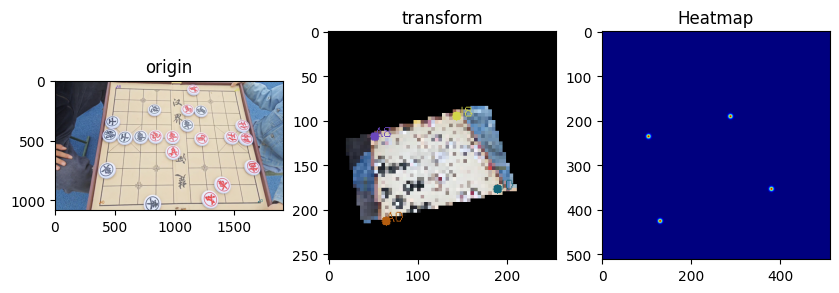

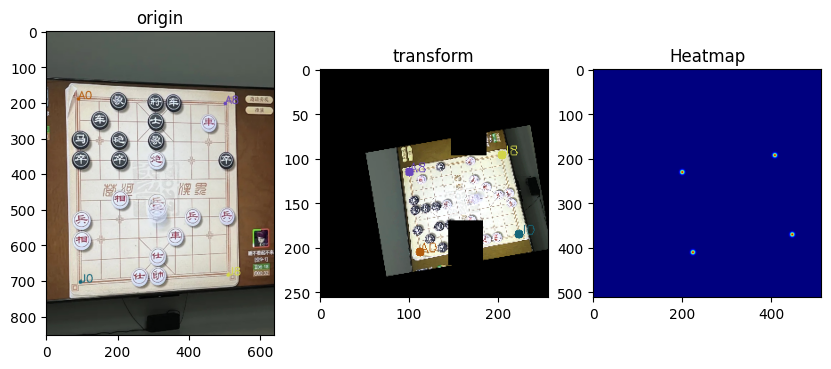

In [13]:
# 循环  10 次
# plt 绘制的图大一点

plt.rcParams['figure.figsize'] = [10, 10]

for i in range(2):
    plt.figure()  # 创建新的图形
    show_origin_and_transform(i+11)
    plt.show()    # 显示当前图形
    plt.close()   # 关闭当前图形以释放内存
